In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix

In [2]:
# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/cogtext/abstracts_clusters.csv.gz', index_col=0)
weights = np.load('models/cogtext/abstracts_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

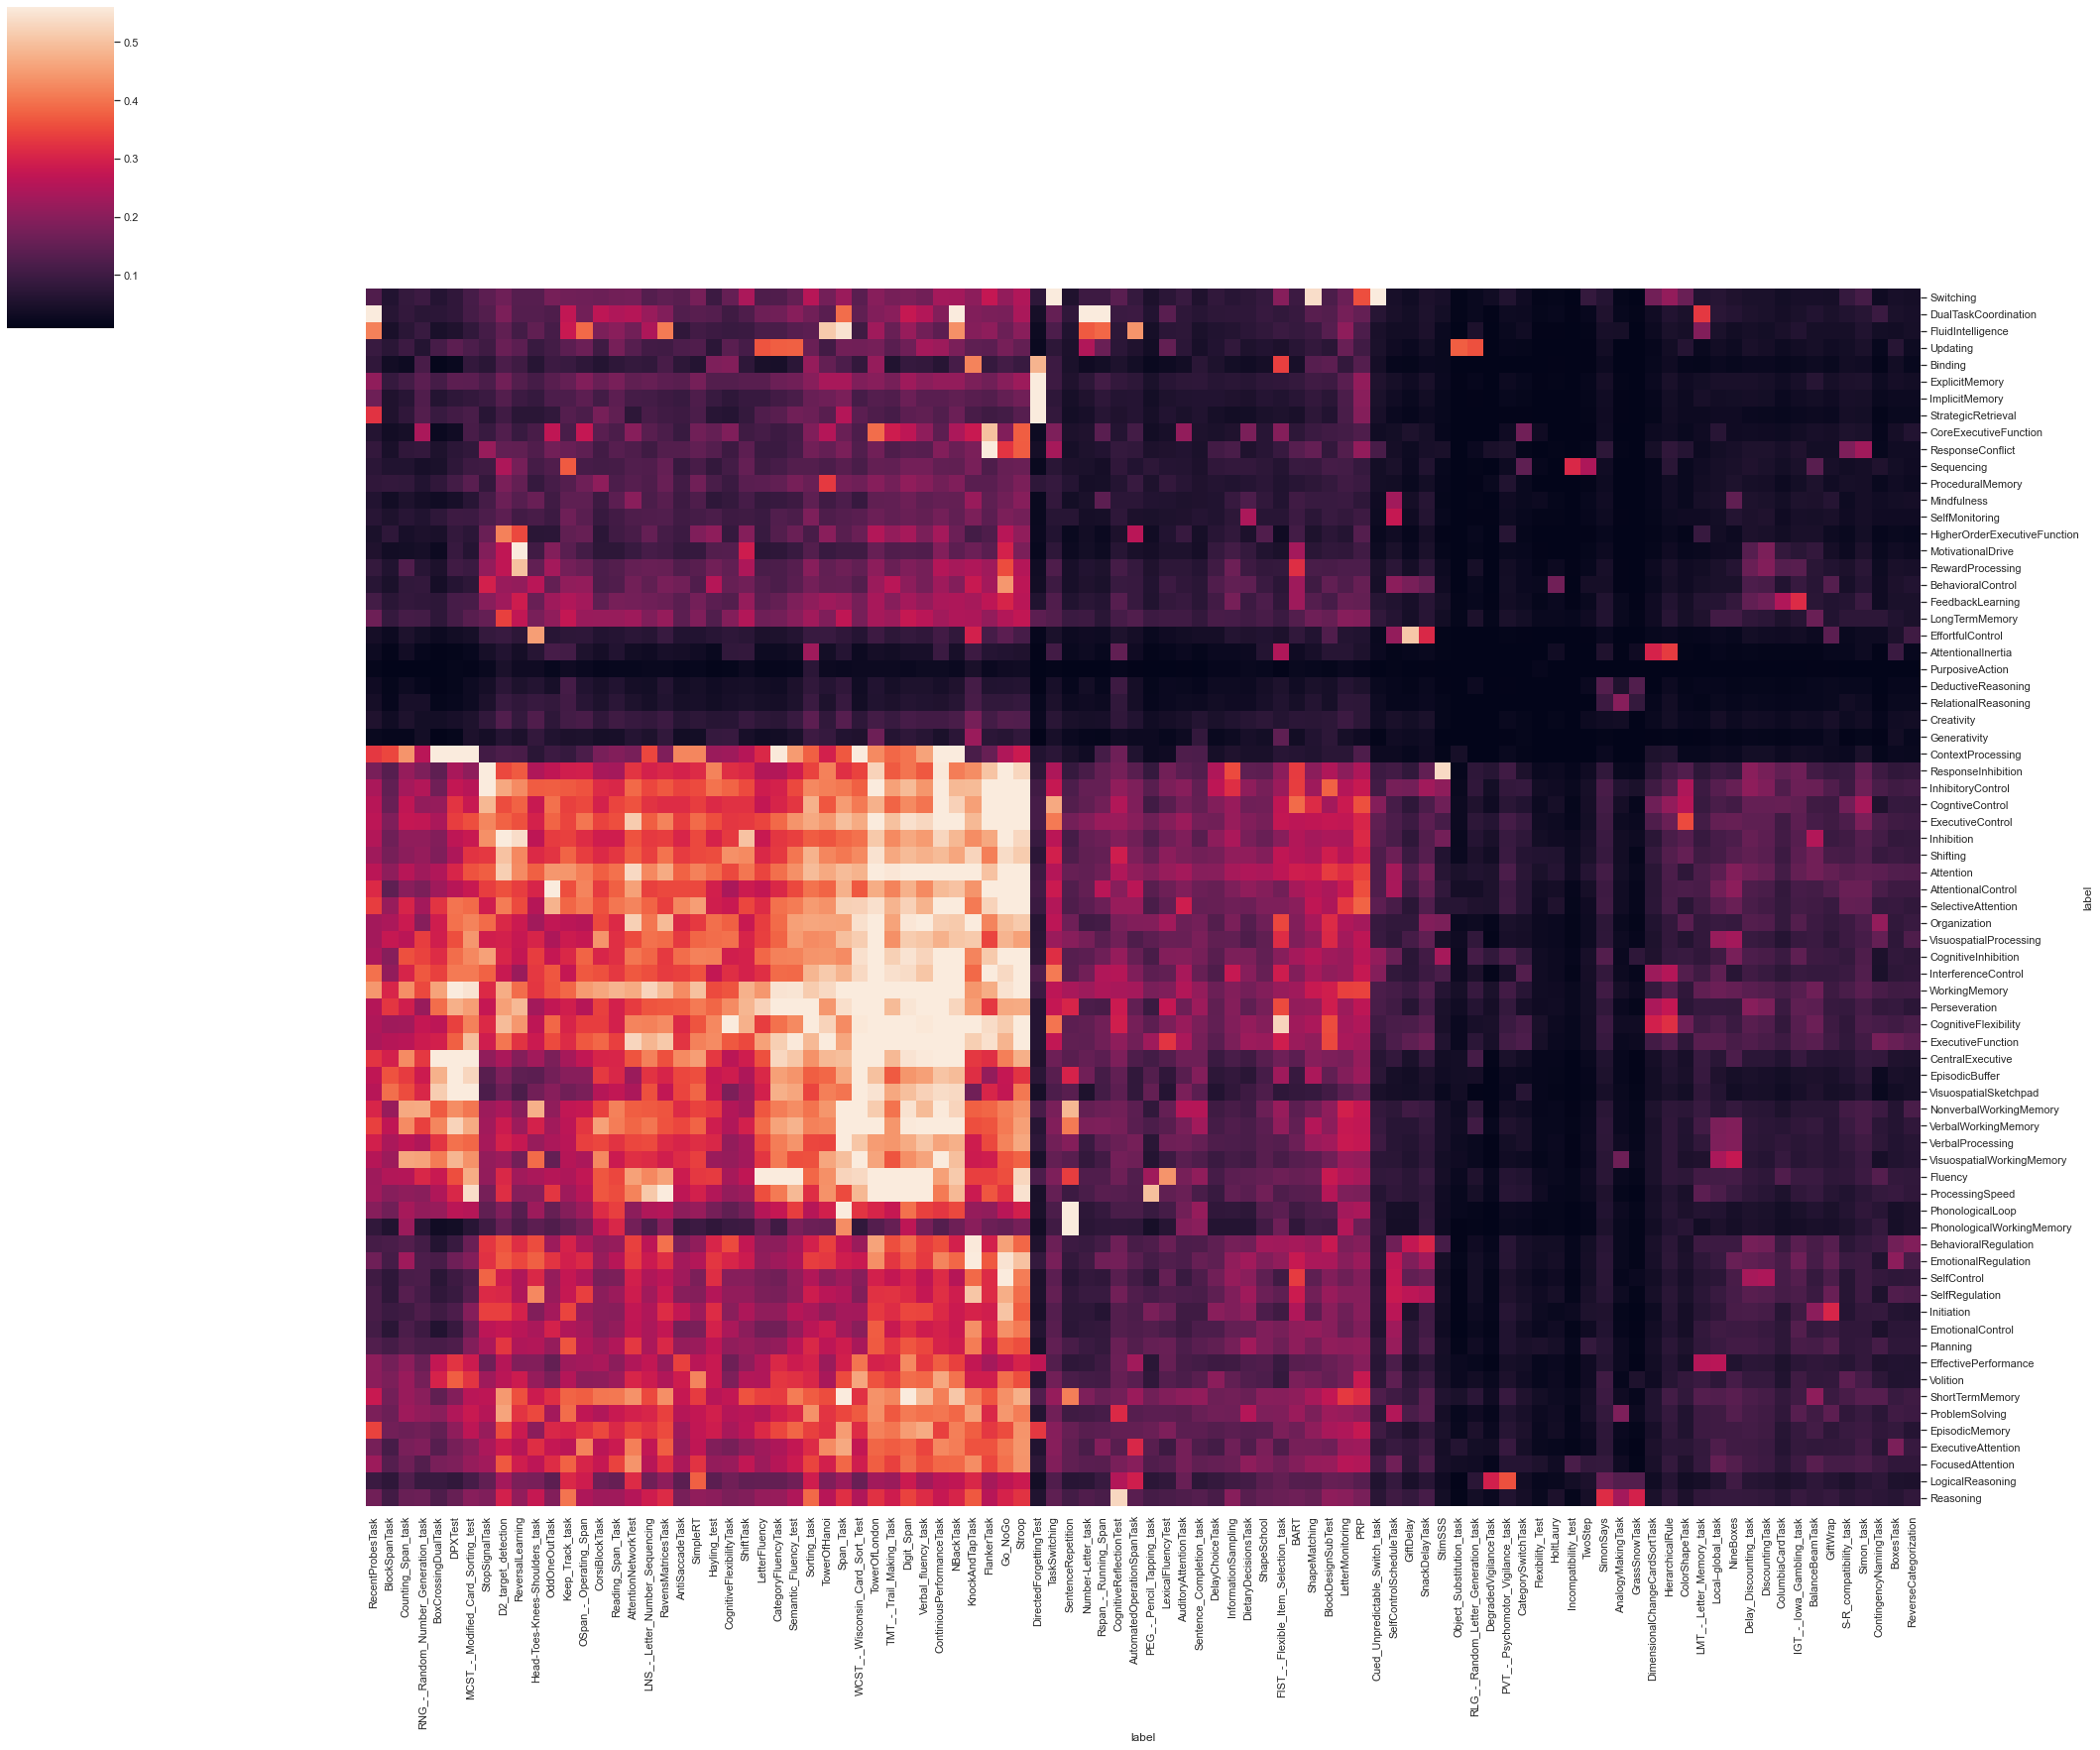

In [10]:
# create label-label similarity matrix

# create label-embeddings by mean-pooling doc-embeddings of each label
label_embeddings = pubmed.groupby('label')['weights'].apply(np.mean)
label_embeddings = pd.DataFrame(np.stack(label_embeddings), index=label_embeddings.index)

def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]

# add categories of labels
label_embeddings['category'] = label_embeddings.index.to_series().apply(find_category_by_label)
label_embeddings.set_index(['category'], append=True, inplace=True)

# now generate the similarity matrix
labels_sim = get_similarity_matrix(label_embeddings, metric='kl')

# heatmap plot categorized by label category, either task or construct
g = sns.clustermap(labels_sim, figsize=(30, 25), robust=True)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.show()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


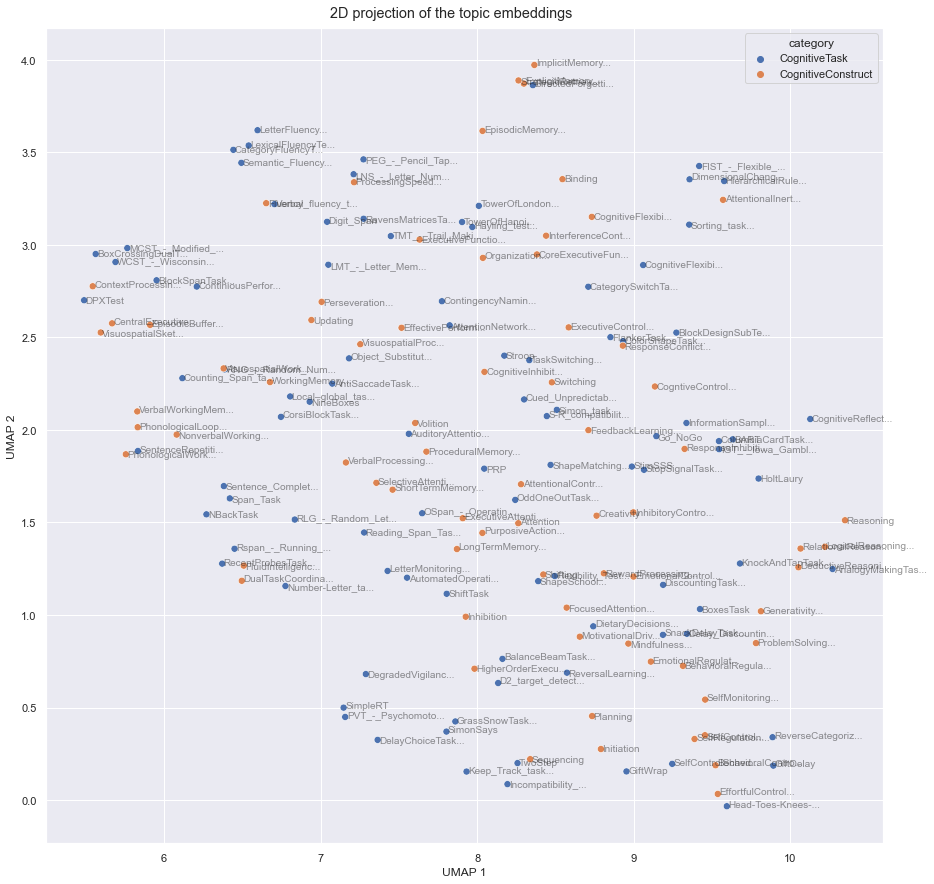

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections = UMAP(n_components=2, random_state=0).fit_transform(label_embeddings)

projections = pd.DataFrame(projections, index=label_embeddings.index)

sns.scatterplot(data=projections, x=0, y=1, ax=ax, s=50, hue='category')

for ((lbl,_), x, y) in projections.itertuples():
  lbl = f'{lbl[:16]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=10)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

In [12]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,tensorflow,python.cogtext,scikit-learn

Last updated: 2021-12-06T09:55:13.918716+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.2
pytorch       : not installed
tensorflow    : 2.7.0
python.cogtext: 0.1.2021120609
scikit-learn  : 0.0

pandas    : 1.3.4
matplotlib: 3.4.3
numpy     : 1.20.3
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:19) 
[Clang 11.1.0 ]
seaborn   : 0.11.2

